In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from collections import Counter
import shutil

In [2]:
# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))

In [3]:
# Resample function to balance each class to 500 samples
def resample_data(directory, target_count=500):
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        images = glob(os.path.join(class_path, "*.jpg"))
        current_count = len(images)
        if current_count < target_count:
            # Augment the class to have `target_count` images
            for i in range(target_count - current_count):
                image = images[i % current_count]
                image_name = os.path.basename(image)
                new_image_name = f"aug_{i}_{image_name}"
                new_image_path = os.path.join(class_path, new_image_name)
                shutil.copy(image, new_image_path)
        elif current_count > target_count:
            # Reduce the class to `target_count` images
            for image in images[target_count:]:
                os.remove(image)
                

In [4]:
## Resample training data
#resample_data(train_dir)


# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 8018 images belonging to 7 classes.
Found 2005 images belonging to 7 classes.
Found 1515 images belonging to 7 classes.


In [5]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
import os

# Load the InceptionResNetV2 model without the top fully connected layers (include_top=False)
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

# Freeze the base_model layers to prevent them from being trained
for layer in base_model.layers[-30:]:
    layer.trainable = False
    
## Unfreeze the top layers for fine-tuning
#for layer in base_model.layers[-30:]:
#    layer.trainable = True

# Add custom layers on top of the base model without L2 regularization
x = base_model.output
x = Dropout(0.8)(x)
x = GlobalAveragePooling2D()(x)

# Add Dense layers without L2 regularization
x = Dense(128, activation='relu')(x)
x = Dropout(0.8)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.8)(x)
x = Dense(32, activation='relu')(x)

# Final output layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

# Summary of the model
model.summary()

# Metrics callback for precision
class MetricsCallback(Callback):
    def __init__(self, val_generator):
        super(MetricsCallback, self).__init__()
        self.val_generator = val_generator

    def on_epoch_end(self, epoch, logs=None):
        y_true = self.val_generator.classes
        y_pred = self.model.predict(self.val_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate precision only
        precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

        val_loss = logs['val_loss']
        val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

        print(f'Epoch {epoch + 1} - '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}, '
              f'Validation Precision: {precision:.4f}')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Metrics callback
metrics_callback = MetricsCallback(val_generator)

from tensorflow.keras.callbacks import ModelCheckpoint

# Define the callback to save the best model
checkpoint = ModelCheckpoint(
    'withoutresampleandlegurazarion12.h5',       # Path to save the model
    monitor='val_loss',     # Metric to monitor ('val_loss' or 'val_accuracy')
    save_best_only=True,    # Save only the best model
    mode='min',             # Save model when the validation loss decreases ('min' for loss, 'max' for accuracy)
    verbose=1
)

# Train the model with ModelCheckpoint
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, metrics_callback, checkpoint, reduce_lr],
    verbose=2
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 299, 224, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 299, 224, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 521s - loss: 1.2682 - acc: 0.5909 - val_loss: 1.0208 - val_acc: 0.6688 - lr: 1.0000e-04 - 521s/epoch - 1s/step
Epoch 2/1000
126/126 [==============================] - 34s 273ms/step
Epoch 2 - Validation Loss: 1.0550, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 2: val_loss did not improve from 1.02077
502/502 - 499s - loss: 1.0253 - acc: 0.6618 - val_loss: 1.0550 - val_acc: 0.6688 - lr: 1.0000e-04 - 499s/epoch - 994ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 274ms/step
Epoch 3 - Validation Loss: 1.1796, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 3: val_loss did not improve from 1.02077
502/502 - 499s - loss: 0.9405 - acc: 0.6677 - val_loss: 1.1796 - val_acc: 0.6688 - lr: 1.0000e-04 - 499s/epoch - 993ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 274ms/step
Epoch 4 - Validation Loss: 0.9300, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 4: val_loss improved from 1.02077 to 0.92995, saving model to withoutresampleandlegurazarion12.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 501s - loss: 0.9040 - acc: 0.6685 - val_loss: 0.9300 - val_acc: 0.6688 - lr: 1.0000e-04 - 501s/epoch - 998ms/step
Epoch 5/1000
126/126 [==============================] - 34s 273ms/step
Epoch 5 - Validation Loss: 0.8775, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 5: val_loss improved from 0.92995 to 0.87754, saving model to withoutresampleandlegurazarion12.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 501s - loss: 0.8444 - acc: 0.6687 - val_loss: 0.8775 - val_acc: 0.6688 - lr: 1.0000e-04 - 501s/epoch - 997ms/step
Epoch 6/1000
126/126 [==============================] - 34s 274ms/step
Epoch 6 - Validation Loss: 0.8884, Validation Accuracy: 0.6688, Validation Precision: 0.4473

Epoch 6: val_loss did not improve from 0.87754
502/502 - 499s - loss: 0.8196 - acc: 0.6694 - val_loss: 0.8884 - val_acc: 0.6688 - lr: 1.0000e-04 - 499s/epoch - 994ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 273ms/step
Epoch 7 - Validation Loss: 0.9252, Validation Accuracy: 0.7002, Validation Precision: 0.4542

Epoch 7: val_loss did not improve from 0.87754
502/502 - 498s - loss: 0.8128 - acc: 0.6711 - val_loss: 0.9252 - val_acc: 0.7002 - lr: 1.0000e-04 - 498s/epoch - 992ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 273ms/step
Epoch 8 - Validation Loss: 0.7978, Validation Accuracy: 0.6813, Validation Precision: 0.4693

Epoch 8: val_loss improved from 0.87754 to 0.79782, saving model to withoutresampleandlegurazarion12.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 500s - loss: 0.8006 - acc: 0.6810 - val_loss: 0.7978 - val_acc: 0.6813 - lr: 1.0000e-04 - 500s/epoch - 996ms/step
Epoch 9/1000
126/126 [==============================] - 34s 273ms/step
Epoch 9 - Validation Loss: 0.8299, Validation Accuracy: 0.7406, Validation Precision: 0.4727

Epoch 9: val_loss did not improve from 0.79782
502/502 - 498s - loss: 0.7958 - acc: 0.6972 - val_loss: 0.8299 - val_acc: 0.7406 - lr: 1.0000e-04 - 498s/epoch - 993ms/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 273ms/step
Epoch 10 - Validation Loss: 0.8382, Validation Accuracy: 0.7397, Validation Precision: 0.4813

Epoch 10: val_loss did not improve from 0.79782
502/502 - 499s - loss: 0.7627 - acc: 0.7146 - val_loss: 0.8382 - val_acc: 0.7397 - lr: 1.0000e-04 - 499s/epoch - 994ms/step
Epoch 11/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 273ms/step
Epoch 11 - Validation Loss: 0.9385, Validation Accuracy: 0.6893, Validation Precision: 0.4837

Epoch 11: val_loss did not improve from 0.79782
502/502 - 499s - loss: 0.7479 - acc: 0.7245 - val_loss: 0.9385 - val_acc: 0.6893 - lr: 1.0000e-04 - 499s/epoch - 993ms/step
Epoch 12/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 272ms/step
Epoch 12 - Validation Loss: 0.8215, Validation Accuracy: 0.7257, Validation Precision: 0.4770

Epoch 12: val_loss did not improve from 0.79782
502/502 - 497s - loss: 0.7295 - acc: 0.7250 - val_loss: 0.8215 - val_acc: 0.7257 - lr: 1.0000e-04 - 497s/epoch - 991ms/step
Epoch 13/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 272ms/step
Epoch 13 - Validation Loss: 0.9518, Validation Accuracy: 0.6554, Validation Precision: 0.4666

Epoch 13: val_loss did not improve from 0.79782
502/502 - 496s - loss: 0.7187 - acc: 0.7342 - val_loss: 0.9518 - val_acc: 0.6554 - lr: 1.0000e-04 - 496s/epoch - 989ms/step
Epoch 14/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 272ms/step
Epoch 14 - Validation Loss: 0.8015, Validation Accuracy: 0.7332, Validation Precision: 0.4628

Epoch 14: val_loss did not improve from 0.79782
502/502 - 495s - loss: 0.6642 - acc: 0.7487 - val_loss: 0.8015 - val_acc: 0.7332 - lr: 5.0000e-05 - 495s/epoch - 986ms/step
Epoch 15/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 280ms/step
Epoch 15 - Validation Loss: 0.8930, Validation Accuracy: 0.6544, Validation Precision: 0.4644

Epoch 15: val_loss did not improve from 0.79782
502/502 - 511s - loss: 0.6519 - acc: 0.7478 - val_loss: 0.8930 - val_acc: 0.6544 - lr: 5.0000e-05 - 511s/epoch - 1s/step
Epoch 16/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 275ms/step
Epoch 16 - Validation Loss: 0.8971, Validation Accuracy: 0.6589, Validation Precision: 0.4621

Epoch 16: val_loss did not improve from 0.79782
502/502 - 509s - loss: 0.6432 - acc: 0.7492 - val_loss: 0.8971 - val_acc: 0.6589 - lr: 5.0000e-05 - 509s/epoch - 1s/step
Epoch 17/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 285ms/step
Epoch 17 - Validation Loss: 0.7765, Validation Accuracy: 0.6998, Validation Precision: 0.4623

Epoch 17: val_loss improved from 0.79782 to 0.77651, saving model to withoutresampleandlegurazarion12.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 511s - loss: 0.6263 - acc: 0.7537 - val_loss: 0.7765 - val_acc: 0.6998 - lr: 5.0000e-05 - 511s/epoch - 1s/step
Epoch 18/1000
126/126 [==============================] - 35s 278ms/step
Epoch 18 - Validation Loss: 0.8002, Validation Accuracy: 0.7087, Validation Precision: 0.4828

Epoch 18: val_loss did not improve from 0.77651
502/502 - 512s - loss: 0.6210 - acc: 0.7541 - val_loss: 0.8002 - val_acc: 0.7087 - lr: 5.0000e-05 - 512s/epoch - 1s/step
Epoch 19/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 278ms/step
Epoch 19 - Validation Loss: 0.8112, Validation Accuracy: 0.6594, Validation Precision: 0.4649

Epoch 19: val_loss did not improve from 0.77651
502/502 - 505s - loss: 0.6059 - acc: 0.7590 - val_loss: 0.8112 - val_acc: 0.6594 - lr: 5.0000e-05 - 505s/epoch - 1s/step
Epoch 20/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 278ms/step
Epoch 20 - Validation Loss: 0.8662, Validation Accuracy: 0.6369, Validation Precision: 0.4697

Epoch 20: val_loss did not improve from 0.77651
502/502 - 507s - loss: 0.5908 - acc: 0.7635 - val_loss: 0.8662 - val_acc: 0.6369 - lr: 5.0000e-05 - 507s/epoch - 1s/step
Epoch 21/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 280ms/step
Epoch 21 - Validation Loss: 0.8093, Validation Accuracy: 0.6818, Validation Precision: 0.4635

Epoch 21: val_loss did not improve from 0.77651
502/502 - 510s - loss: 0.5926 - acc: 0.7660 - val_loss: 0.8093 - val_acc: 0.6818 - lr: 5.0000e-05 - 510s/epoch - 1s/step
Epoch 22/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 280ms/step
Epoch 22 - Validation Loss: 0.7990, Validation Accuracy: 0.6693, Validation Precision: 0.4598

Epoch 22: val_loss did not improve from 0.77651
502/502 - 507s - loss: 0.5839 - acc: 0.7706 - val_loss: 0.7990 - val_acc: 0.6693 - lr: 5.0000e-05 - 507s/epoch - 1s/step
Epoch 23/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 280ms/step
Epoch 23 - Validation Loss: 0.7509, Validation Accuracy: 0.7162, Validation Precision: 0.4659

Epoch 23: val_loss improved from 0.77651 to 0.75089, saving model to withoutresampleandlegurazarion12.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 507s - loss: 0.5692 - acc: 0.7761 - val_loss: 0.7509 - val_acc: 0.7162 - lr: 2.5000e-05 - 507s/epoch - 1s/step
Epoch 24/1000
126/126 [==============================] - 35s 279ms/step
Epoch 24 - Validation Loss: 0.7300, Validation Accuracy: 0.7337, Validation Precision: 0.4714

Epoch 24: val_loss improved from 0.75089 to 0.73002, saving model to withoutresampleandlegurazarion12.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 507s - loss: 0.5473 - acc: 0.7844 - val_loss: 0.7300 - val_acc: 0.7337 - lr: 2.5000e-05 - 507s/epoch - 1s/step
Epoch 25/1000


KeyboardInterrupt: 

In [6]:
# Calculate precision, recall, and f1 score after training
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final F1 Score: {f1_score:.4f}')

126/126 [==============================] - 34s 269ms/step
Final Precision: 0.4897
Final Recall: 0.4818
Final F1 Score: 0.4854


95/95 [==============================] - 26s 274ms/step - loss: 0.7165 - acc: 0.8158
Test accuracy: 0.815841555595398


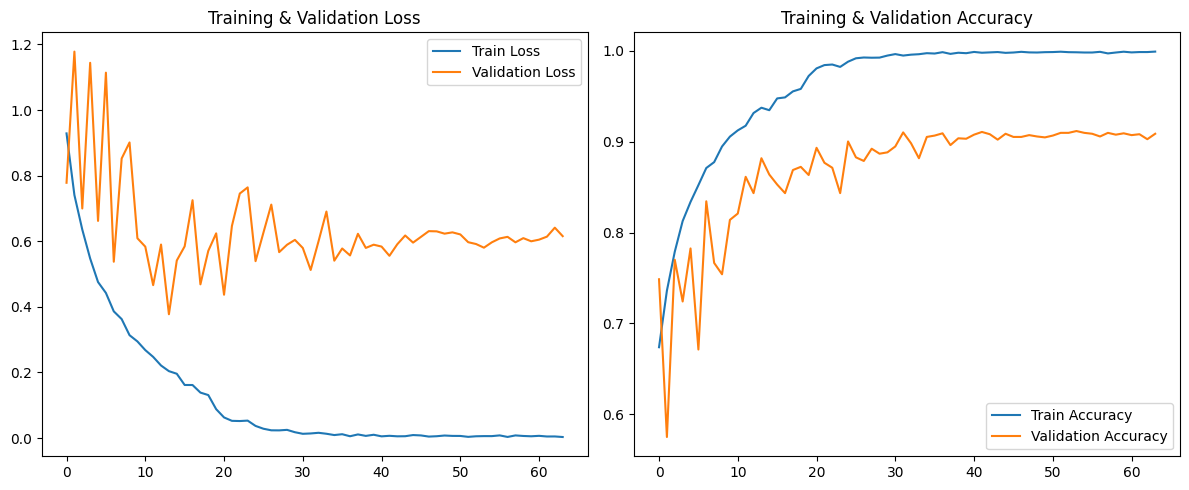

In [7]:
# Evaluate the model on the test set
test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])

# Plot the training and validation accuracy and loss at each epoch
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Training & Validation Loss
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].legend()
axs[0].set_title('Training & Validation Loss')

# Plot Training & Validation Accuracy
axs[1].plot(history.history['acc'], label='Train Accuracy')
axs[1].plot(history.history['val_acc'], label='Validation Accuracy')
axs[1].legend()
axs[1].set_title('Training & Validation Accuracy')

plt.tight_layout()
plt.show()

502/502 [==============================] - 218s 434ms/step


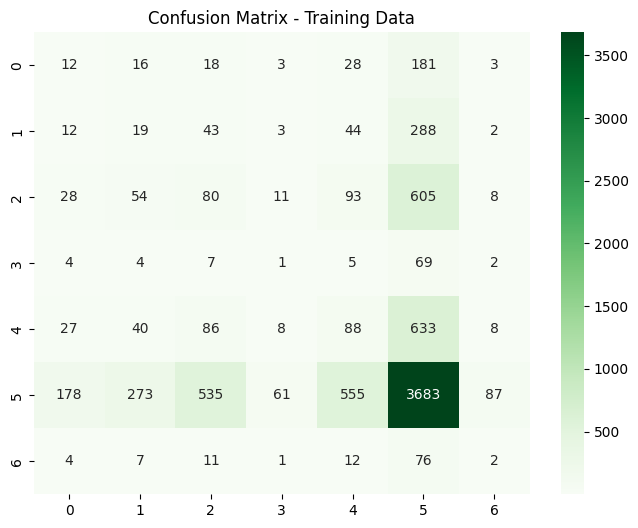

126/126 [==============================] - 34s 268ms/step


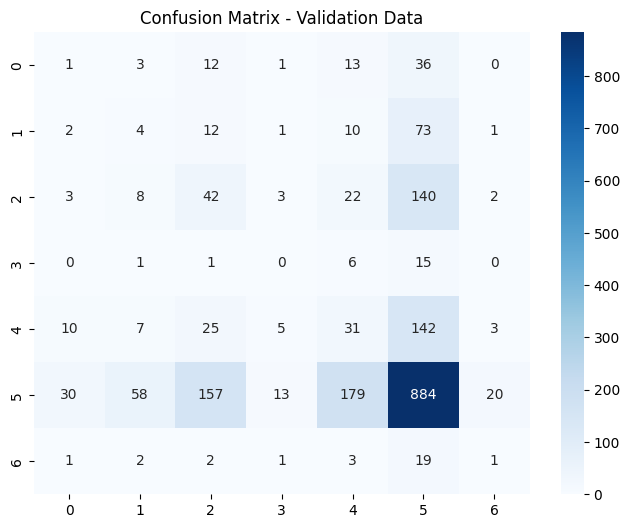

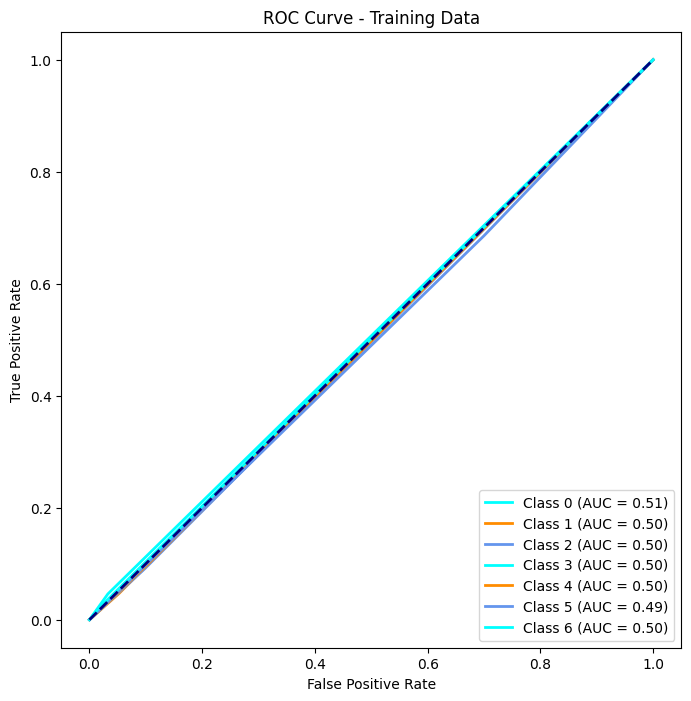

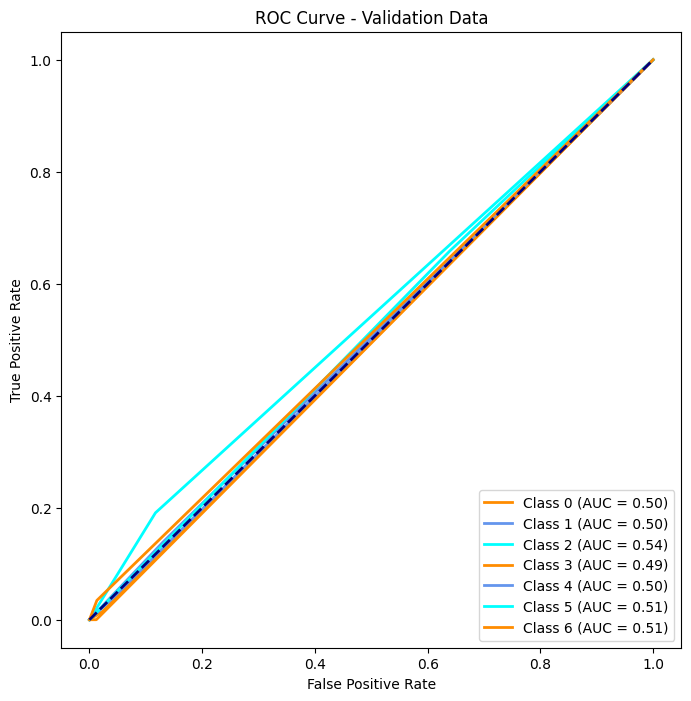

In [8]:
# Confusion matrix for training data
y_train_true = train_generator.classes
y_train_pred = model.predict(train_generator)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
cm_train = confusion_matrix(y_train_true, y_train_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Training Data')
plt.show()

# Confusion matrix for validation data
y_val_true = val_generator.classes
y_val_pred = model.predict(val_generator)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
cm_val = confusion_matrix(y_val_true, y_val_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Data')
plt.show()

# AUC-ROC curve for training data
y_train_true_binary = label_binarize(y_train_true, classes=np.unique(y_train_true))
y_train_pred_binary = label_binarize(y_train_pred_classes, classes=np.unique(y_train_true))

fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()

for i in range(NUM_CLASSES):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_true_binary[:, i], y_train_pred_binary[:, i])
    roc_auc_train[i] = roc_auc_score(y_train_true_binary[:, i], y_train_pred_binary[:, i])

plt.figure(figsize=(8, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_train[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Data')
plt.legend(loc='lower right')
plt.show()

# AUC-ROC curve for validation data
y_val_true_binary = label_binarize(y_val_true, classes=np.unique(y_val_true))
y_val_pred_binary = label_binarize(y_val_pred_classes, classes=np.unique(y_val_true))

fpr_val = dict()
tpr_val = dict()
roc_auc_val = dict()

for i in range(NUM_CLASSES):
    fpr_val[i], tpr_val[i], _ = roc_curve(y_val_true_binary[:, i], y_val_pred_binary[:, i])
    roc_auc_val[i] = roc_auc_score(y_val_true_binary[:, i], y_val_pred_binary[:, i])

plt.figure(figsize=(8, 8))
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_val[i], tpr_val[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_val[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Data')
plt.legend(loc='lower right')
plt.show()


In [9]:
x, y  = train_generator.__getitem__(0)

y

array([[0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [10]:
x, y  = test_generator.__getitem__(0)

y

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [11]:
x, y  = val_generator.__getitem__(0)

y

array([[0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [12]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('InceptionResNetV2.1.h5')

# Verify the model structure
model.summary()



OSError: No file or directory found at InceptionResNetV2.1.h5

In [23]:
# Paths
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 1515 images belonging to 7 classes.


In [24]:
test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])

95/95 [==============================] - 28s 271ms/step - loss: 0.7602 - acc: 0.8350
Test accuracy: 0.8349835276603699


In [25]:
x, y  = test_generator.__getitem__(0)

y

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]], dtype=float32)